<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Using Natural Language Processing (NLP) Modelling to Predict Desktop CPU Brand Popularity

# Part 4 - NLP Model Training
### Contents:

- [Base Model](#Base-Model)
- [Model Benchmarking](#Model-Benchmarking)
- [Model Selection](#Model-Selection)


In [1]:
#Library imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

import re
import spacy


In [2]:
#read the train_df Data
df = pd.read_csv('./train_csv.csv')

In [3]:
#loading the english language small model of spacy and appending amd and intel into stop words.
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
sw_spacy = list(sw_spacy)

#creating a new list of stopwords and removing those with apostrophe as those will be removed by the tokenizers anyways
new_spacy = []
for word in sw_spacy:
    if "'" not in word:
        new_spacy.append(word)

new_spacy.append('amd')    #adding dead giveaway words
new_spacy.append('intel')
new_spacy.append('ll')     #adding words that caused Warnings when running a model
new_spacy.append('ve')
new_spacy.append('nt')

---

## Base Model

This is to set a base model from which we will peg future model performance to. This will be run on default mostly except for ```max_features = 5_000``` which is constant throughout all the models.

#### CountVectorizer + Logistic Regression on Monograms w/ Stopwords = ['amd', 'intel']

In [4]:
#Setting X and y
X = df['text']
y = df['subreddit_isAMD']

#Splitting the dataset to Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

#initiating a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = ['amd', 'intel'])),
    ('lr', LogisticRegression())
])

#setting up pipe parameters
pipe_params = {
    'cvec__max_features': [5_000],
    'lr__max_iter' : [5_000],
}

#instantiating a Gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5,
                  n_jobs=-1
                 )

#fitting
gs.fit(X_train, y_train);

#saving the performance into a DataFrame
performance_df = pd.DataFrame()
df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,"CountVectorizer(stop_words=['amd', 'intel'])",LogisticRegression(),0.915816,0.986182,0.916625,"{'cvec__max_features': 5000, 'lr__max_iter': 5..."


---

## Model Benchmarking

We will be using 2 vectorizers, CountVectorizer and TfidfVectorizer, and 3 classifiers, LogisticRegression, MultinomialNB, and RandomForestClassifier. The main yardstick to compare across models are their Cross-Val Score, Train Score, and Test Score, with Test Score being the one used if there are comparable performance between models.

**Vectorizers and Classifiers Used**<br>
Note: Hyperparameters are kept constant for all runs as per below table

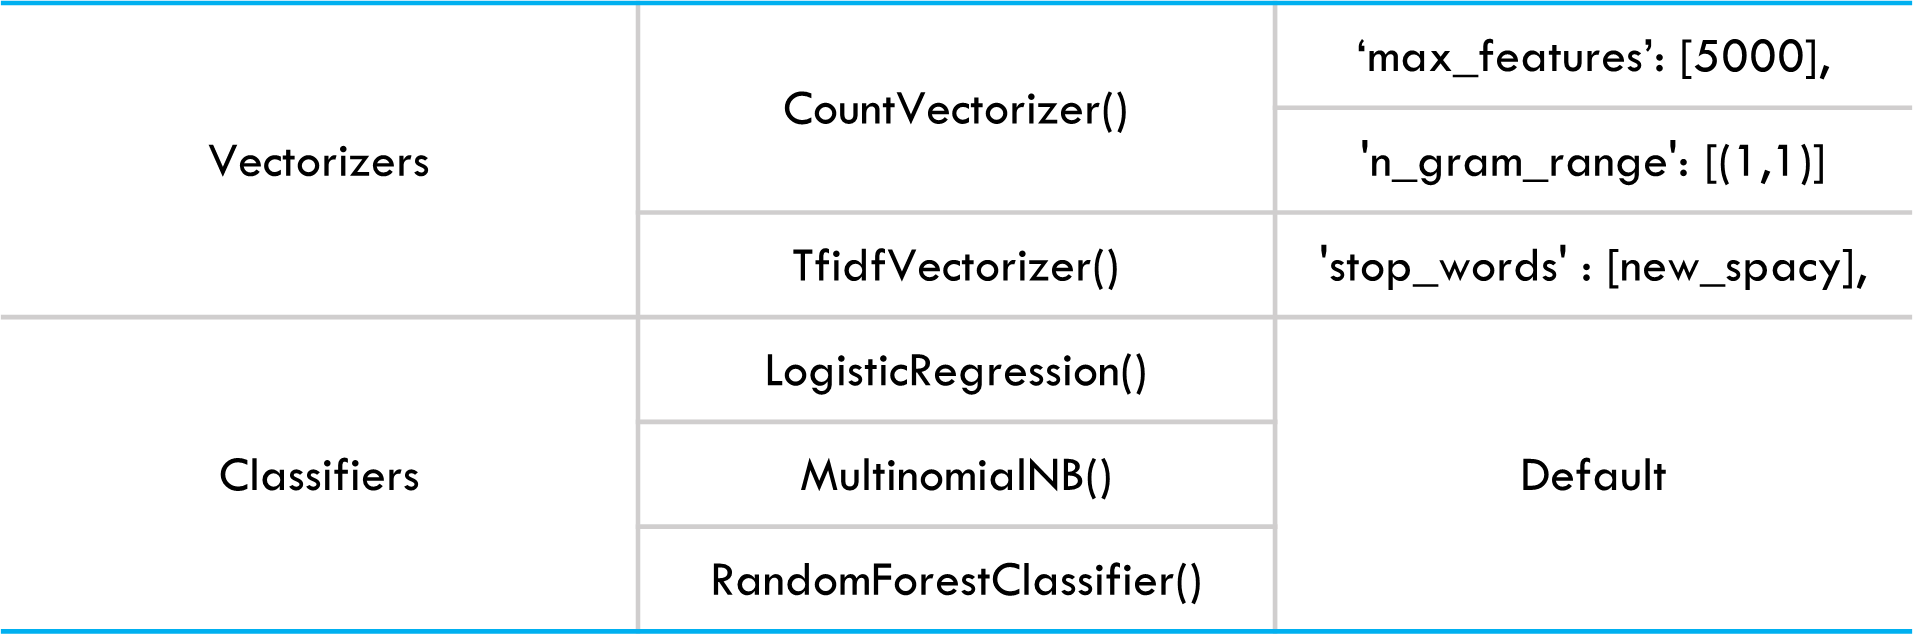

#### CountVectorizer + LogisticRegression

In [5]:
#Setting X and y
X = df['text']
y = df['subreddit_isAMD']

#Splitting the dataset to Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

#initiating a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = new_spacy)),
    ('lr', LogisticRegression(max_iter = 5_000))
])

#setting up pipe parameters
pipe_params = {
    'cvec__max_features': [5_000],
    'cvec__ngram_range': [(1,1)]
}

#instantiating a Gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=5,
                  n_jobs= -1,
                  ) 

#fitting
gs.fit(X_train, y_train)

#saving the performance into a DataFrame
df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,"CountVectorizer(stop_words=['amd', 'intel'])",LogisticRegression(),0.915816,0.986182,0.916625,"{'cvec__max_features': 5000, 'lr__max_iter': 5..."
1,"CountVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.919534,0.985128,0.922117,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."


#### CountVectorizer + MultinomialNB

In [6]:
#Setting X and y
X = df['text']
y = df['subreddit_isAMD']

#Splitting the dataset to Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

#initiating a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = new_spacy)),
    ('nb', MultinomialNB()),
     ])


#setting up pipe parameters
pipe_params = {
    'cvec__max_features': [5_000],
    'cvec__ngram_range': [(1,1)]
}

#instantiating a Gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=5,
                  n_jobs= -1,
                  ) 

#fitting
gs.fit(X_train, y_train)

#saving the performance into a DataFrame
df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,"CountVectorizer(stop_words=['amd', 'intel'])",LogisticRegression(),0.915816,0.986182,0.916625,"{'cvec__max_features': 5000, 'lr__max_iter': 5..."
1,"CountVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.919534,0.985128,0.922117,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
2,"CountVectorizer(stop_words=['towards', 'many',...",MultinomialNB(),0.914206,0.928635,0.910634,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."


#### Count Vectorizer + Random Forest

In [7]:
#Setting X and y
X = df['text']
y = df['subreddit_isAMD']

#Splitting the dataset to Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

#initiating a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = new_spacy)),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

#setting up pipe parameters
rf_params = {
    'cvec__max_features': [5_000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
}

#instantiating a Gridsearch
gs = GridSearchCV(
    pipe,
    param_grid = rf_params,
    cv = 5,
    n_jobs = -1,
)

#fitting
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,"CountVectorizer(stop_words=['amd', 'intel'])",LogisticRegression(),0.915816,0.986182,0.916625,"{'cvec__max_features': 5000, 'lr__max_iter': 5..."
1,"CountVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.919534,0.985128,0.922117,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
2,"CountVectorizer(stop_words=['towards', 'many',...",MultinomialNB(),0.914206,0.928635,0.910634,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
3,"CountVectorizer(stop_words=['towards', 'many',...",RandomForestClassifier(n_jobs=-1),0.921199,0.998724,0.926111,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."


#### TFIDF Vectorizer + LogisticRegression

In [8]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = new_spacy)),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'tvec__max_features': [5000],
    'tvec__ngram_range': [(1,1)]
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,"CountVectorizer(stop_words=['amd', 'intel'])",LogisticRegression(),0.915816,0.986182,0.916625,"{'cvec__max_features': 5000, 'lr__max_iter': 5..."
1,"CountVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.919534,0.985128,0.922117,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
2,"CountVectorizer(stop_words=['towards', 'many',...",MultinomialNB(),0.914206,0.928635,0.910634,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
3,"CountVectorizer(stop_words=['towards', 'many',...",RandomForestClassifier(n_jobs=-1),0.921199,0.998724,0.926111,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
4,"TfidfVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.927358,0.957103,0.929106,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."


#### TFIDF Vectorizer + MultinomialNB

In [9]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = new_spacy)),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [5_000],
    'tvec__ngram_range': [(1,1)]
}

gs = GridSearchCV(
    pipe,
    param_grid=pipe_params,
    cv = 5,
    n_jobs= -1,
)

gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,"CountVectorizer(stop_words=['amd', 'intel'])",LogisticRegression(),0.915816,0.986182,0.916625,"{'cvec__max_features': 5000, 'lr__max_iter': 5..."
1,"CountVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.919534,0.985128,0.922117,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
2,"CountVectorizer(stop_words=['towards', 'many',...",MultinomialNB(),0.914206,0.928635,0.910634,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
3,"CountVectorizer(stop_words=['towards', 'many',...",RandomForestClassifier(n_jobs=-1),0.921199,0.998724,0.926111,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
4,"TfidfVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.927358,0.957103,0.929106,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."
5,"TfidfVectorizer(stop_words=['towards', 'many',...",MultinomialNB(),0.909767,0.928801,0.913630,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."


#### TFIDF Vectorizer + Random Forest

In [10]:
X = df['text']
y = df['subreddit_isAMD']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 123,
    stratify = y,
)

pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = new_spacy)),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

rf_params = {
    'tvec__max_features': [5_000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
}

gs = GridSearchCV(
    pipe,
    param_grid = rf_params,
    cv = 5,
    n_jobs = -1,
)
gs.fit(X_train, y_train)

df_temp = pd.DataFrame({'Vectorizer': [str(pipe[0])], 'Classifier': [str(pipe[1])], 'Cross-Val Score': [gs.best_score_], 'Train Score': [gs.score(X_train, y_train)], 'Test Score':[gs.score(X_test, y_test)], 'params': [str(gs.best_params_)]})
performance_df = pd.concat([performance_df, df_temp], ignore_index = True, axis = 0)
performance_df

,Vectorizer,Classifier,Cross-Val Score,Train Score,Test Score,params
0,"CountVectorizer(stop_words=['amd', 'intel'])",LogisticRegression(),0.915816,0.986182,0.916625,"{'cvec__max_features': 5000, 'lr__max_iter': 5..."
1,"CountVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.919534,0.985128,0.922117,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
2,"CountVectorizer(stop_words=['towards', 'many',...",MultinomialNB(),0.914206,0.928635,0.910634,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
3,"CountVectorizer(stop_words=['towards', 'many',...",RandomForestClassifier(n_jobs=-1),0.921199,0.998724,0.926111,"{'cvec__max_features': 5000, 'cvec__ngram_rang..."
4,"TfidfVectorizer(stop_words=['towards', 'many',...",LogisticRegression(max_iter=5000),0.927358,0.957103,0.929106,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."
5,"TfidfVectorizer(stop_words=['towards', 'many',...",MultinomialNB(),0.909767,0.928801,0.913630,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."
6,"TfidfVectorizer(stop_words=['towards', 'many',...",RandomForestClassifier(n_jobs=-1),0.919145,0.998724,0.926610,"{'tvec__max_features': 5000, 'tvec__ngram_rang..."


---

## Model Selection

The model that utilizes TfidfVectorizer and LogisticRegression will be used for future feature engineering and hyperparameter tuning as it has the best accuracy scores across the board (index number 4 in the DataFrame above).

In [15]:
performance_df.to_csv('performance_df2.csv', index=False)